In [1]:
import numpy as np
import networks as nt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'pdf.fonttype': 42, 'ps.fonttype': 42})
plt.rcParams.update({'font.size': 10, 'font.family': 'Helvetica'})

In [2]:
N = 10
seed_perturbation = 1
seed_network = 1
seed_signal = 1

time_c = 2
time_r = 1.1
dt = 4e-5
lambd = 5
threshold = 0.85
freq = 2 * np.pi / time_c
neurons2plot = [0, 2, 7]
alpha = 1.5

flow = ['baseline', 'deaths', 'births', 'noise', 'rec-noise']
values = [0, 0.3, 2, 0.1, 0.05]
s_mag = 8
beta = 1.11 * 2 * np.pi / time_c
bias = 0

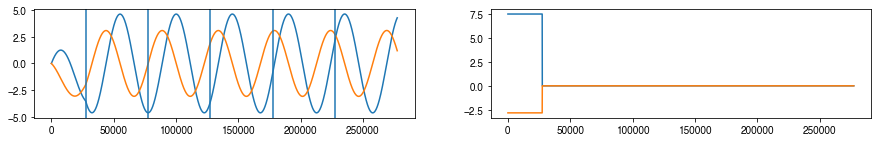

In [3]:
# First create the signal
np.random.seed(seed_signal)
A = np.array([[bias, alpha * beta], [-beta / alpha, bias]])
T_r = int(time_r / dt)
T_c = int(time_c / dt)
T = T_r + len(flow) * T_c
B = np.zeros((T, 2))
amps = np.random.randn(2)
amps *= s_mag / np.linalg.norm(amps)
B[:T_r, :] = amps
X = np.zeros((T + 1, 2))
for i in range(1, T):
    X[i + 1, :] = X[i, :] + dt * (np.dot(A, X[i, :]) + B[i, :])
Xdot = np.diff(X.T).T / dt
X = X[:-1, :]
C = Xdot + lambd * X
fig, ax = plt.subplots(1, 2, figsize=(15, 2))
ax[0].plot(X)
for i in range(len(flow)):
    ax[0].axvline(T_r + i * T_c)
ax[1].plot(B)
total_time = time_r + time_c * len(flow)
time = np.linspace(0, total_time, T + 1)

In [4]:
np.random.seed(seed_network)
D = np.random.randn(2, N)
for i in range(N):
    D[:, i] /= np.linalg.norm(D[:, i])
F = D.copy().T
Omega = np.dot(F, D)
Omega_slow = np.dot(F, np.dot(A + lambd * np.eye(2), D))
Th = threshold * np.ones(N)

Rg = np.zeros((T, N))
Vg = np.zeros((T, N))
dV = np.zeros((T_r, N))
Xh = np.zeros((T, 2))
print(Xh.shape)

Np = N
delay = 0
noise = 0
tmpspikefailure = 0
# Ramp up
R, Spikesg, V, Rn, Vn = nt.sim_slow(A, B[:T_r, :], F, Omega, Omega_slow, Th, dt, dV, lambd, delay, np.zeros(N), np.zeros(N), voltages=True, D=D, readout_correction=True)
Rg[:T_r, :] = R
Vg[:T_r, :] = V
Xh_c = np.zeros((R.shape[0], D.shape[0]))
for i in range(R.shape[0]):
    xh = np.dot(D, R[i, :])
    if np.linalg.norm(xh) > 0:
        Xh_c[i, :] = xh * (1 + (threshold - 0.5) / np.linalg.norm(xh))
Xh[:T_r, :] = Xh_c

F_m = F.copy()
D_m = D.copy()
Omega_m = Omega.copy()
Th_m = Th.copy()

# Now let's cycle
for i, cycle in enumerate(flow):
    d = nt.build_dict(noise, True)
    
    if cycle == 'noise':
        noise = values[i]
        d['noise'] = noise
    d[cycle] = values[i]
        
    F_m, Omega_m, Th_m, D_m, dV_m, Nc, N_dead_neurons = nt.modify_params(T_c, F_m, Omega_m, Th_m, D_m, d, dt, seed=seed_perturbation * i, random_death=True)
    print(Th_m)
    if cycle == 'death':
        Omega_slow_m = np.dot(F_m, np.dot(A + lambd * np.eye(2), D))
    else:
        Omega_slow_m = np.dot(F_m, np.dot(A + lambd * np.eye(2), D_m))
    print(cycle)
    print(Np, Nc)
    print('Number of neurons alive:', np.sum((Th_m < np.inf) * 1), ' N:', Th_m.shape, ' Th_m:', Th_m)
    print('F_m.shape:', F_m.shape, 'Omega_m.shape:', Omega_m.shape, 'Th_m.shape:', Th_m.shape, 'D_m.shape:', D_m.shape)
    if Nc > Np:
        Rn = np.concatenate((Rn, np.zeros(Nc - Np)))
        Vaux = np.dot(F_m[Np:, :], np.mean(np.dot(R[-1000:, :], D_m[:, :Np].T), axis=0) - np.dot(D_m, Rn))
        Vaux = -0.25 * np.ones(Nc - Np)
        Vn = np.concatenate((Vn, Vaux))
    
    R, Spikes, V, Rn, Vn = nt.sim_slow(A, B[(T_r + i * T_c):(T_r + (i + 1) * T_c), :], F_m, Omega_m, Omega_slow_m, Th_m, dt, dV_m, lambd, delay, Rn, Vn, voltages=True, tmpspikefailure=tmpspikefailure, D=D_m, readout_correction=True)
    Xh_c = np.zeros((R.shape[0], D_m.shape[0]))
    for i_corr in range(R.shape[0]):
        xh = np.dot(D_m, R[i_corr, :])
        if np.linalg.norm(xh) > 0:
            Xh_c[i_corr, :] = xh * (1 + (threshold - 0.5) / np.linalg.norm(xh))
    Xh[(T_r + i * T_c):(T_r + (i + 1) * T_c), :] = Xh_c
    
    if Nc > Np:
        Rgaux = np.zeros((T, Nc))
        Vgaux = np.full([T, Nc], np.nan)
        Rgaux[:, :Np] = Rg
        Vgaux[:, :Np] = Vg
        Rgaux[(T_r + i * T_c):(T_r + (i + 1) * T_c), :] = R
        Vgaux[(T_r + i * T_c):(T_r + (i + 1) * T_c), :] = V
        Rg = Rgaux
        Vg = Vgaux
    else:
        Rg[(T_r + i * T_c):(T_r + (i + 1) * T_c), :] = R
        Vg[(T_r + i * T_c):(T_r + (i + 1) * T_c), :] = V
    if Nc > Np:
        Spikesgaux = [[] for i in range(Nc)]
        for j in range(Np):
            Spikesgaux[j] = Spikesg[j] + [T_r + i * T_c + spike for spike in Spikes[j]]
        for j in range(Np, Nc):
            Spikesgaux[j] = [T_r + i * T_c + spike for spike in Spikes[j]]
        Spikesg = Spikesgaux
    else:
        for j in range(Nc):
            Spikesg[j] = Spikesg[j] + [T_r + i * T_c + spike for spike in Spikes[j]] 
    Np = Nc

(277495, 2)
dt 4e-05 ref 75 delay 0 N 10 most saturated neuron:  0.0 average saturated neuron: 0.0
[0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85]
baseline
10 10
Number of neurons alive: 10  N: (10,)  Th_m: [0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85]
F_m.shape: (10, 2) Omega_m.shape: (10, 10) Th_m.shape: (10,) D_m.shape: (2, 10)
dt 4e-05 ref 75 delay 0 N 10 most saturated neuron:  0.0 average saturated neuron: 0.0
[0.85 0.85  inf 0.85 0.85 0.85  inf 0.85 0.85  inf]
deaths
10 10
Number of neurons alive: 7  N: (10,)  Th_m: [0.85 0.85  inf 0.85 0.85 0.85  inf 0.85 0.85  inf]
F_m.shape: (10, 2) Omega_m.shape: (10, 10) Th_m.shape: (10,) D_m.shape: (2, 10)
dt 4e-05 ref 75 delay 0 N 10 most saturated neuron:  0.0 average saturated neuron: 0.0
[0.85 0.85  inf 0.85 0.85 0.85  inf 0.85 0.85  inf 0.85 0.85 0.85 0.85
 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85]
births
10 24
Number of neurons alive: 21  N: (24,)  Th_m: [0.85 0.85  inf 0.85 0.85 0.85  inf 0.85 0.85  inf 0.85 0.85 

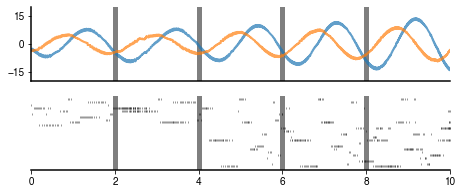

In [5]:
no_plots = 2
axis_lw = 1.5
signal_lw = 2
scalex = 0.5
scaley = 0.5
fig, ax = plt.subplots(no_plots, 1, figsize=(scalex * 3 * len(flow), scaley * 3 * no_plots))

ax_signal = ax[0]
ax_raster = ax[1]

for i in range(1, len(flow)):
    ax_signal.axvline(T_r + i * T_c, color='black', alpha=0.5, linewidth=5)
    ax_raster.axvline(T_r + i * T_c, color='black', alpha=0.5, linewidth=5) 

ax_signal.plot(Xh, alpha=0.7, linewidth=signal_lw)
ax_signal.set_yticks([-15, 0, 15])
ax_signal.set_ylim([-20, 20])
ax_signal.set_xticks([])
ax_signal.spines['bottom'].set_linewidth(axis_lw)
ax_signal.spines['left'].set_linewidth(axis_lw)

for i in range(Nc):
    ax_raster.plot([spike for spike in Spikesg[i]], i * np.ones(len(Spikesg[i])), '|k', markersize=2, markeredgewidth=1, alpha=0.4)
ax_raster.invert_yaxis()
ax_raster.spines['left'].set_visible(False)
ax_raster.set_yticks([])
ax_raster.spines['bottom'].set_linewidth(axis_lw)


for i in range(no_plots):
    ax[i].set_xlim(T_r, T)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
ax[i].set_xticks([T_r + i * T_c for i in range(len(flow) + 1)])
ax[i].set_xticklabels([2 * i for i in range(len(flow) + 1)])

fig.savefig('FIG1D.pdf', transparent=True)